In [52]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

from typing import Annotated, Literal, List, Dict, Any
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage

In [53]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI()
llm.invoke("Hey there, how are you?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 14, 'total_tokens': 47, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoM5VNVN7EEDz5d9nl3aLv9TI65Ap', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f5d06ae1-fd9f-444a-b80a-a23ecd87b6ab-0', usage_metadata={'input_tokens': 14, 'output_tokens': 33, 'total_tokens': 47, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [54]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
search_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [55]:
members=["researcher","coder"]
options = members+["FINISH"]

In [56]:
class Router(TypedDict):
    next: Literal["researcher", "coder", "FINISH"]

In [57]:
class State(MessagesState):
    next:str

In [58]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [59]:
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_54649/2387125992.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_54649/2387125992.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [60]:
def supervisor(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output = llm.with_structured_output(Router)
    response = llm_with_structure_output.invoke(messages)
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    return Command(goto=goto, update={"next":goto})

In [61]:
def researcher(state: State) -> Command[Literal['supervisor']]:
    
    research = create_react_agent(llm, tools=[search_tool], prompt = "You are just a researcher, tasked with finding information based on the user request. Do not do any math")
    result = research.invoke(state)

    return Command(update = {"messages":[HumanMessage(content=result["messages"][-1].content, name="researcher")]}, goto="supervisor")

In [62]:
def coder(state: State) -> Command[Literal['supervisor']]:
    code_agent = create_react_agent(llm, tools = [python_repl_tool], prompt = "You are just a code, do not do any research.")
    
    return Command(update = {"messages":[HumanMessage(content=code_agent.invoke(state)["messages"][-1].content, name="coder")]}, goto="supervisor")

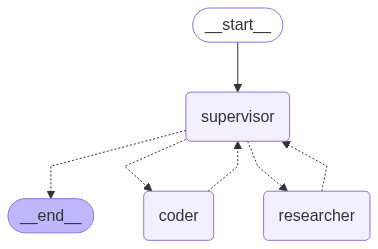

In [63]:
graph = StateGraph(MessagesState)

graph.add_node('supervisor', supervisor)
graph.add_node('researcher', researcher)
graph.add_node('coder', coder)

graph.add_edge(START, 'supervisor')

app = graph.compile()

app

In [66]:
for s in app.stream({"messages": [("user", "What is the csquare root of 42")]}, subgraphs = True):
    print(s)

/Users/rhy/Library/CloudStorage/OneDrive-ArizonaStateUniversity/SelfStudy/Agentic & Gen AI with Cloud/agenticai/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
(('researcher:7f690e03-1a2a-f81e-c3b9-6b4a4099ee4f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Yy69dLYpy4uhIRufoJObX6Bf', 'function': {'arguments': '{"query":"csquare root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 112, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoMJv741Q3EpVXEP55oHeNoJnecDq', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--543093d0-95e5-4758-94d3-921db6895ec2-0', tool_calls=[{'name': 'tavily_search_resu

/Users/rhy/Library/CloudStorage/OneDrive-ArizonaStateUniversity/SelfStudy/Agentic & Gen AI with Cloud/agenticai/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


**********BELOW IS MY GOTO***************
FINISH
((), {'supervisor': {'next': '__end__'}})
